### We can load saved models in 2 ways

In [1]:
import os
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
FAST_RUN = False
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Using TensorFlow backend.


#### Preparing Images to Test df

In [2]:
test_dir = './data/test'
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    "file_name": test_filenames
})
nb_samples = test_df.shape[0]
test_df.head()

,file_name
0,472.jpg
1,388.jpg
2,414.jpg
3,443.jpg
4,391.jpg


#### Creating Generator out of test images df

In [3]:
batch_size=15
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_dir, 
    x_col='file_name',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 325 validated image filenames.


### 1. Loading models with Architecture
After training a model, we save the architecture and weights into `.h5` file using `model.save('cat_or_dog_model_epoc50.h5')`

In [4]:
from keras.models import load_model

In [5]:
model = load_model('models/cat_or_dog_model_epoc50.h5')
model.summary()

W0709 18:38:01.271442 139647835789120 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 18:38:01.313458 139647835789120 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 18:38:01.342096 139647835789120 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 18:38:01.342871 139647835789120 deprecation_wrapper.py:119] From /home/mo/anaconda3/envs/inception35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
__________

In [6]:
def predict_gen(model, test_generator, nb_samples, batch_size):
    predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
    test_df['category'] = np.argmax(predict, axis=-1)
#     print(test_df.head())
    test_df["category"] = test_df["category"].replace({0: 'cat', 1: 'dog'})
#     print(test_df.head())
    plot(test_df)

In [7]:
def plot(test_df):
    from keras.preprocessing import image

    sample_test = test_df.head(18)
    sample_test.head()
    plt.figure(figsize=(12, 24))
    for index, row in sample_test.iterrows():
        filename = row['file_name']
        category = row['category']
        img = image.load_img(test_dir + "/" + filename, target_size=IMAGE_SIZE)
        plt.subplot(6, 3, index+1)
        plt.imshow(img)
        plt.xlabel(filename + '(' + "{}".format(category) + ')' )
    plt.tight_layout()
    plt.show()

### Predict and Plot

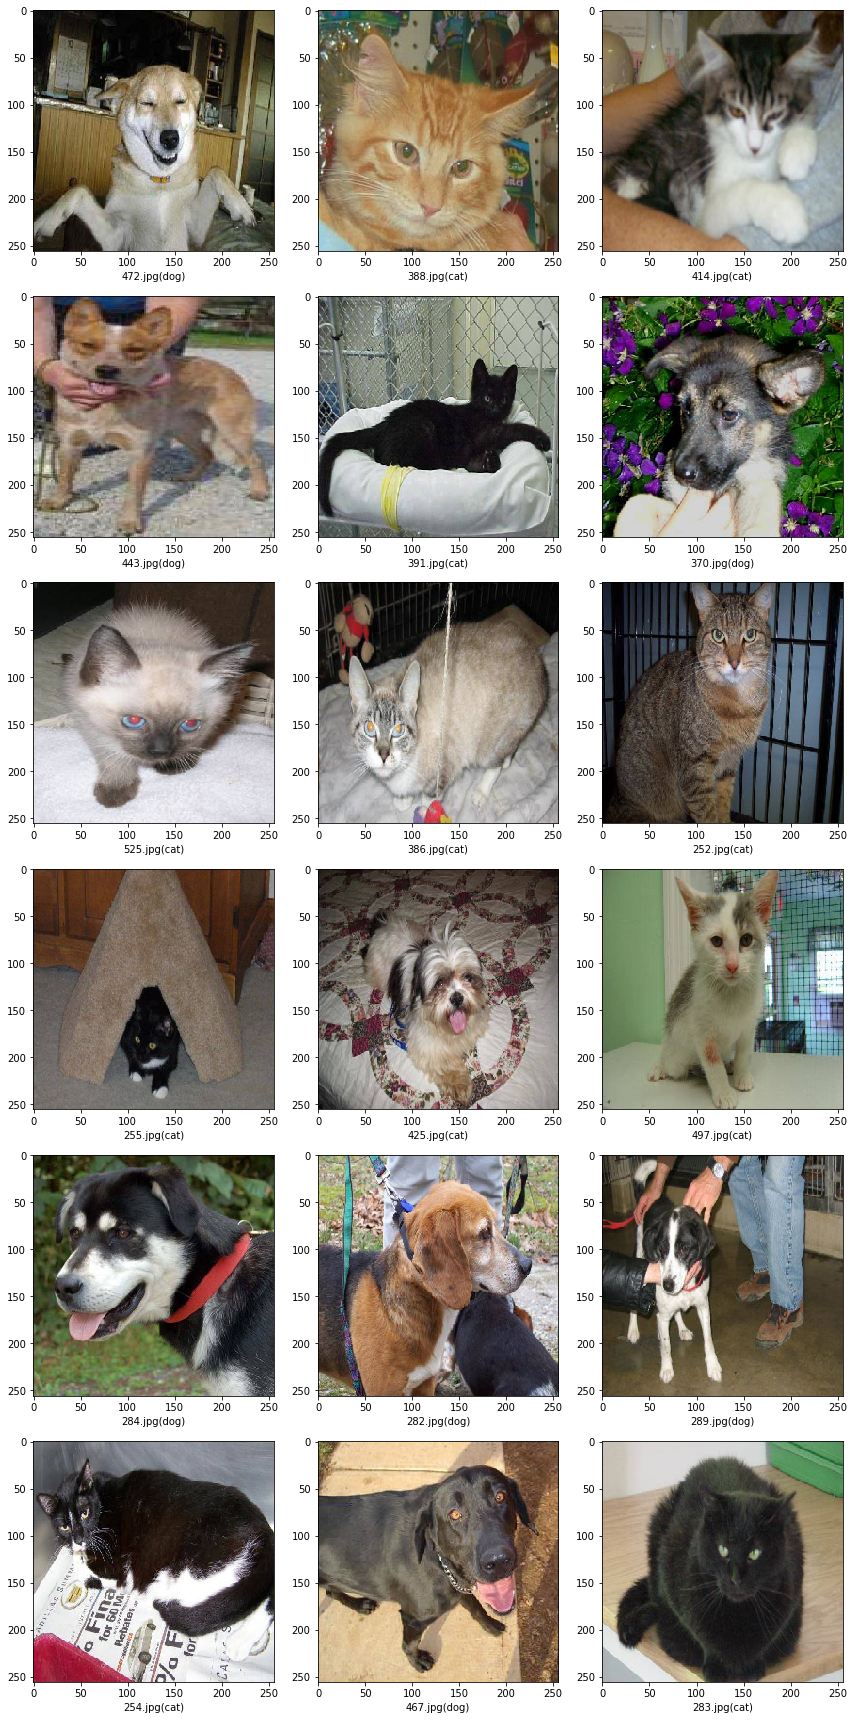

In [8]:
predict_gen(model, test_generator, nb_samples, batch_size)

### 2. Loading models after creating the Architecture
First we create the same architecture that we used for training and we load our weights (`model.save_weights('weights_epoc50.h5')` saved while training) to the Architecture
using.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 254, 254, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
__________

In [ ]:
model.load_weights('models/weights_epoc50.h5')

In [ ]:
model.summary()

In [ ]:
predict_gen(model, test_generator, nb_samples, batch_size)